In [2]:
%pip install pyevtk

/bin/bash: /home/co21btech11008/miniconda3/envs/cuNu/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Note: you may need to restart the kernel to use updated packages.


In [5]:
def ternary_numpy(n):
    import numpy as np
    from legate.timing import time
    # Set random seed for reproducibility
    np.random.seed(714)

    # Grid dimensions and constants
    Nx, Ny = n, n
    dx, dy = 1.0, 1.0  # Spatial resolution
    dt = 0.1  # Time step

    # Initialize concentrations
    cA = (1.0 / 3) + np.random.normal(0, 0.001, (Nx, Ny))
    cB = (1.0 / 3) + np.random.normal(0, 0.001, (Nx, Ny))
    cC = 1 - cA - cB

    start_time = time()

    # Create wave number arrays adjusted for rfft2
    kx = 2 * np.pi * np.fft.rfftfreq(Nx, d=dx)
    ky = 2 * np.pi * np.fft.fftfreq(Ny, d=dy)
    kx, ky = np.meshgrid(kx, ky)
    k2 = kx**2 + ky**2
    k4 = k2**2

    # Constants for the differential operators and reaction parameters
    M_AA, M_BB, M_AB = 1, 1, 0.5
    kA, kB, kC = 1.0, 1.0, 1.0
    kAA = kA + kC
    kBB = kB + kC
    kAB = kC
    A1, A2, A3, B = 1.0, 1.0, 1.0, 12.0

    # Precompute lhs
    lhsA = 1 + 2 * dt * k4 * (M_AA * kAA - M_AB * kAB)
    lhsB = 1 + 2 * dt * k4 * (M_BB * kBB - M_AB * kAB)

    # Coordinates
    x = np.arange(0, Nx) * dx
    y = np.arange(0, Ny) * dy
    z = np.zeros(1)  # Since this is a 2D data set

    # Simulation loop
    for n in range(2000):
        gA = 2 * A1 * cA * cB**2 - 2 * A2 * cB**2 * cC - 2 * A3 * cA**2 * cC + 2 * A3 * cA * cC**2 - 2 * B * cA**2 * cB**2 * cC + 2 * B * cA * cB**2 * cC**2
        gB = 2 * A1 * cA**2 * cB - 2 * A2 * cB**2 * cC + 2 * A2 * cB * cC**2 - 2 * A3 * cA**2 * cC - 2 * B * cA**2 * cB**2 * cC + 2 * B * cA**2 * cB * cC**2
        
        # Fourier transforms
        cA_tilda = np.fft.rfft2(cA)
        cB_tilda = np.fft.rfft2(cB)
        gA_tilda = np.fft.rfft2(gA)
        gB_tilda = np.fft.rfft2(gB)

        # Update in Fourier space
        cA_tilda = (cA_tilda - k2 * dt * (M_AA * gA_tilda - M_AB * gB_tilda) - 2 * k4 * dt * cB_tilda * (M_AA * kAB - M_AB * kBB)) / lhsA
        cB_tilda = (cB_tilda - k2 * dt * (M_BB * gB_tilda - M_AB * gA_tilda) - 2 * k4 * dt * cA_tilda * (M_BB * kAB - M_AB * kAA)) / lhsB

        # Inverse Fourier transforms to update concentrations
        cA = np.fft.irfft2(cA_tilda)
        cB = np.fft.irfft2(cB_tilda)
        cC = 1 - cA - cB

        # Clip concentrations
        cA = np.clip(cA, 0, 1)
        cB = np.clip(cB, 0, 1)
        cC = np.clip(cC, 0, 1)

        # Compute microstructure
        microstruct = np.zeros((Nx, Ny))
        microstruct = np.where((cA < 0.5) & (cB < 0.5) & (cC < 0.5), 0, microstruct)
        microstruct = np.where(cA > 0.5, cA, microstruct)
        microstruct = np.where(cB > 0.5, 0.65 * cB, microstruct)
        microstruct = np.where(cC > 0.5, 0.35 * cC, microstruct)

        # Output to VTK format at specified intervals
        # if n % 200 == 0:
        #     gridToVTK(f"./microstruct_{n}", x, y, z, pointData={"microstruct": microstruct.reshape((Nx, Ny, 1))})
    # The VTK files can now be visualized using Paraview
        
        # Visualization at specified intervals
        # if n % 2000 == 0:
        #     plt.imshow(microstruct, cmap='jet')
        #     plt.colorbar()
        #     plt.title(f"Microstructure at Step {n}")
        #     plt.show()
        end_time = time()
        execution_time  = end_time - start_time
        return execution_time


In [6]:
def ternary_cunumeric(n):
    '''
    Uses numpy for fftfreq and rfftfreq 
    '''
    import cunumeric as np
    from legate.timing import time
    # Set random seed for reproducibility
    np.random.seed(714)

    # Grid dimensions and constants
    Nx, Ny = n, n
    dx, dy = 1.0, 1.0  # Spatial resolution
    dt = 0.1  # Time step

    # Initialize concentrations
    cA = (1.0 / 3) + np.random.normal(0, 0.001, (Nx, Ny))
    cB = (1.0 / 3) + np.random.normal(0, 0.001, (Nx, Ny))
    cC = 1 - cA - cB

    start_time = time()

    # Create wave number arrays adjusted for rfft2
    kx = 2 * np.pi * np.fft.rfftfreq(Nx, d=dx)
    ky = 2 * np.pi * np.fft.fftfreq(Ny, d=dy)
    kx, ky = np.meshgrid(kx, ky)
    k2 = kx**2 + ky**2
    k4 = k2**2

    # Constants for the differential operators and reaction parameters
    M_AA, M_BB, M_AB = 1, 1, 0.5
    kA, kB, kC = 1.0, 1.0, 1.0
    kAA = kA + kC
    kBB = kB + kC
    kAB = kC
    A1, A2, A3, B = 1.0, 1.0, 1.0, 12.0

    # Precompute lhs
    lhsA = 1 + 2 * dt * k4 * (M_AA * kAA - M_AB * kAB)
    lhsB = 1 + 2 * dt * k4 * (M_BB * kBB - M_AB * kAB)

    # Coordinates
    x = np.arange(0, Nx) * dx
    y = np.arange(0, Ny) * dy
    z = np.zeros(1)  # Since this is a 2D data set

    # Simulation loop
    for n in range(2000):
        gA = 2 * A1 * cA * cB**2 - 2 * A2 * cB**2 * cC - 2 * A3 * cA**2 * cC + 2 * A3 * cA * cC**2 - 2 * B * cA**2 * cB**2 * cC + 2 * B * cA * cB**2 * cC**2
        gB = 2 * A1 * cA**2 * cB - 2 * A2 * cB**2 * cC + 2 * A2 * cB * cC**2 - 2 * A3 * cA**2 * cC - 2 * B * cA**2 * cB**2 * cC + 2 * B * cA**2 * cB * cC**2
        
        # Fourier transforms
        cA_tilda = np.fft.rfft2(cA)
        cB_tilda = np.fft.rfft2(cB)
        gA_tilda = np.fft.rfft2(gA)
        gB_tilda = np.fft.rfft2(gB)

        # Update in Fourier space
        cA_tilda = (cA_tilda - k2 * dt * (M_AA * gA_tilda - M_AB * gB_tilda) - 2 * k4 * dt * cB_tilda * (M_AA * kAB - M_AB * kBB)) / lhsA
        cB_tilda = (cB_tilda - k2 * dt * (M_BB * gB_tilda - M_AB * gA_tilda) - 2 * k4 * dt * cA_tilda * (M_BB * kAB - M_AB * kAA)) / lhsB

        # Inverse Fourier transforms to update concentrations
        cA = np.fft.irfft2(cA_tilda)
        cB = np.fft.irfft2(cB_tilda)
        cC = 1 - cA - cB

        # Clip concentrations
        cA = np.clip(cA, 0, 1)
        cB = np.clip(cB, 0, 1)
        cC = np.clip(cC, 0, 1)

        # Compute microstructure
        microstruct = np.zeros((Nx, Ny))
        microstruct = np.where((cA < 0.5) & (cB < 0.5) & (cC < 0.5), 0, microstruct)
        microstruct = np.where(cA > 0.5, cA, microstruct)
        microstruct = np.where(cB > 0.5, 0.65 * cB, microstruct)
        microstruct = np.where(cC > 0.5, 0.35 * cC, microstruct)

        # Output to VTK format at specified intervals
        # if n % 200 == 0:
        #     gridToVTK(f"./microstruct_{n}", x, y, z, pointData={"microstruct": microstruct.reshape((Nx, Ny, 1))})
    # The VTK files can now be visualized using Paraview
        
        # Visualization at specified intervals
        # if n % 2000 == 0:
        #     plt.imshow(microstruct, cmap='jet')
        #     plt.colorbar()
        #     plt.title(f"Microstructure at Step {n}")
        #     plt.show()
        end_time = time()
        execution_time  = end_time - start_time
        return execution_time


In [7]:
def ternary_scipy(n):
    '''
    Uses scipy's fft.rfftfreq, fft.fftfreq, fft.rfft2 and fft.irfft2
    Others are all same as numpy
    '''
    import numpy as np
    import scipy as sc
    from legate.timing import time

    # Set random seed for reproducibility
    np.random.seed(714)

    # Grid dimensions and constants
    Nx, Ny = n, n
    dx, dy = 1.0, 1.0  # Spatial resolution
    dt = 0.1  # Time step

    # Initialize concentrations
    cA = (1.0 / 3) + np.random.normal(0, 0.001, (Nx, Ny))
    cB = (1.0 / 3) + np.random.normal(0, 0.001, (Nx, Ny))
    cC = 1 - cA - cB

    start_time = time()

    # Create wave number arrays adjusted for rfft2
    kx = 2 * np.pi * sc.fft.rfftfreq(Nx, d=dx)
    ky = 2 * np.pi * sc.fft.fftfreq(Ny, d=dy)
    kx, ky = np.meshgrid(kx, ky)
    k2 = kx**2 + ky**2
    k4 = k2**2

    # Constants for the differential operators and reaction parameters
    M_AA, M_BB, M_AB = 1, 1, 0.5
    kA, kB, kC = 1.0, 1.0, 1.0
    kAA = kA + kC
    kBB = kB + kC
    kAB = kC
    A1, A2, A3, B = 1.0, 1.0, 1.0, 12.0

    # Precompute lhs
    lhsA = 1 + 2 * dt * k4 * (M_AA * kAA - M_AB * kAB)
    lhsB = 1 + 2 * dt * k4 * (M_BB * kBB - M_AB * kAB)

    # Coordinates
    x = np.arange(0, Nx) * dx
    y = np.arange(0, Ny) * dy
    z = np.zeros(1)  # Since this is a 2D data set

    # Simulation loop
    for _ in range(2000):
        gA = 2 * A1 * cA * cB**2 - 2 * A2 * cB**2 * cC - 2 * A3 * cA**2 * cC + 2 * A3 * cA * cC**2 - 2 * B * cA**2 * cB**2 * cC + 2 * B * cA * cB**2 * cC**2
        gB = 2 * A1 * cA**2 * cB - 2 * A2 * cB**2 * cC + 2 * A2 * cB * cC**2 - 2 * A3 * cA**2 * cC - 2 * B * cA**2 * cB**2 * cC + 2 * B * cA**2 * cB * cC**2

        # Fourier transforms
        cA_tilda = sc.fft.rfft2(cA)
        cB_tilda = sc.fft.rfft2(cB)
        gA_tilda = sc.fft.rfft2(gA)
        gB_tilda = sc.fft.rfft2(gB)
        

        # Update in Fourier space
        cA_tilda = (cA_tilda - k2 * dt * (M_AA * gA_tilda - M_AB * gB_tilda) - 2 * k4 * dt * cB_tilda * (M_AA * kAB - M_AB * kBB)) / lhsA
        cB_tilda = (cB_tilda - k2 * dt * (M_BB * gB_tilda - M_AB * gA_tilda) - 2 * k4 * dt * cA_tilda * (M_BB * kAB - M_AB * kAA)) / lhsB

        # Inverse Fourier transforms to update concentrations
        cA = sc.fft.irfft2(cA_tilda)
        cB = sc.fft.irfft2(cB_tilda)
        cC = 1 - cA - cB

        # Clip concentrations
        cA = np.clip(cA, 0, 1)
        cB = np.clip(cB, 0, 1)
        cC = np.clip(cC, 0, 1)

        # Compute microstructure
        microstruct = np.zeros((Nx, Ny))
        microstruct = np.where((cA < 0.5) & (cB < 0.5) & (cC < 0.5), 0, microstruct)
        microstruct = np.where(cA > 0.5, cA, microstruct)
        microstruct = np.where(cB > 0.5, 0.65 * cB, microstruct)
        microstruct = np.where(cC > 0.5, 0.35 * cC, microstruct)

        # Output to VTK format at specified intervals
        # if n % 200 == 0:
        #     gridToVTK(f"./microstruct_{n}", x, y, z, pointData={"microstruct": microstruct.reshape((Nx, Ny, 1))})
    # The VTK files can now be visualized using Paraview
        
        # Visualization at specified intervals
        # if n % 2000 == 0:
        #     plt.imshow(microstruct, cmap='jet')
        #     plt.colorbar()
        #     plt.title(f"Microstructure at Step {n}")
        #     plt.show()
    end_time = time()
    execution_time = end_time - start_time
    return execution_time


In [8]:
def ternary_pyfftw(n):
    '''
    Other than rfft2 and irfft2, all are numpy library
    '''
    import pyfftw
    import numpy as np
    from legate.timing import time

    np.random.seed(714)

    # Grid dimensions and constants
    Nx, Ny = n, n
    dx, dy = 1.0, 1.0  # Spatial resolution
    dt = 0.1  # Time step

    # Initialize concentrations
    cA = (1.0 / 3) + np.random.normal(0, 0.001, (Nx, Ny))
    cB = (1.0 / 3) + np.random.normal(0, 0.001, (Nx, Ny))
    cC = 1 - cA - cB

    start_time = time()

    # Create wave number arrays adjusted for rfft2
    kx = 2 * np.pi * np.fft.rfftfreq(Nx, d=dx)
    ky = 2 * np.pi * np.fft.fftfreq(Ny, d=dy)
    kx, ky = np.meshgrid(kx, ky)
    k2 = kx**2 + ky**2
    k4 = k2**2

    # Constants for the differential operators and reaction parameters
    M_AA, M_BB, M_AB = 1, 1, 0.5
    kA, kB, kC = 1.0, 1.0, 1.0
    kAA = kA + kC
    kBB = kB + kC
    kAB = kC
    A1, A2, A3, B = 1.0, 1.0, 1.0, 12.0

    # Precompute lhs
    lhsA = 1 + 2 * dt * k4 * (M_AA * kAA - M_AB * kAB)
    lhsB = 1 + 2 * dt * k4 * (M_BB * kBB - M_AB * kAB)

    # Coordinates
    x = np.arange(0, Nx) * dx
    y = np.arange(0, Ny) * dy
    z = np.zeros(1)  # Since this is a 2D data set

    # Simulation loop
    for n in range(2000):
        gA = 2 * A1 * cA * cB**2 - 2 * A2 * cB**2 * cC - 2 * A3 * cA**2 * cC + 2 * A3 * cA * cC**2 - 2 * B * cA**2 * cB**2 * cC + 2 * B * cA * cB**2 * cC**2
        gB = 2 * A1 * cA**2 * cB - 2 * A2 * cB**2 * cC + 2 * A2 * cB * cC**2 - 2 * A3 * cA**2 * cC - 2 * B * cA**2 * cB**2 * cC + 2 * B * cA**2 * cB * cC**2
        
        # Fourier transforms
        cA_tilda = pyfftw.interfaces.numpy_fft.rfft2(cA)
        cB_tilda = pyfftw.interfaces.numpy_fft.rfft2(cB)
        gA_tilda = pyfftw.interfaces.numpy_fft.rfft2(gA)
        gB_tilda = pyfftw.interfaces.numpy_fft.rfft2(gB)

        # Update in Fourier space
        cA_tilda = (cA_tilda - k2 * dt * (M_AA * gA_tilda - M_AB * gB_tilda) - 2 * k4 * dt * cB_tilda * (M_AA * kAB - M_AB * kBB)) / lhsA
        cB_tilda = (cB_tilda - k2 * dt * (M_BB * gB_tilda - M_AB * gA_tilda) - 2 * k4 * dt * cA_tilda * (M_BB * kAB - M_AB * kAA)) / lhsB

        # Inverse Fourier transforms to update concentrations
        cA = pyfftw.interfaces.numpy_fft.irfft2(cA_tilda)
        cB = pyfftw.interfaces.numpy_fft.irfft2(cB_tilda)
        cC = 1 - cA - cB

        # Clip concentrations
        cA = np.clip(cA, 0, 1)
        cB = np.clip(cB, 0, 1)
        cC = np.clip(cC, 0, 1)

        # Compute microstructure
        microstruct = np.zeros((Nx, Ny))
        microstruct = np.where((cA < 0.5) & (cB < 0.5) & (cC < 0.5), 0, microstruct)
        microstruct = np.where(cA > 0.5, cA, microstruct)
        microstruct = np.where(cB > 0.5, 0.65 * cB, microstruct)
        microstruct = np.where(cC > 0.5, 0.35 * cC, microstruct)


        # Output to VTK format at specified intervals
        # if n % 200 == 0:
        #     gridToVTK(f"./microstruct_{n}", x, y, z, pointData={"microstruct": microstruct.reshape((Nx, Ny, 1))})
        # The VTK files can now be visualized using Paraview

        # Visualization at specified intervals
        # if n % 2000 == 0:
        #     plt.imshow(microstruct, cmap='jet')
        #     plt.colorbar()
        #     plt.title(f"Microstructure at Step {n}")
        #     plt.show()

    end_time = time()
    execution_time = end_time - start_time
    return execution_time


/home/co21btech11008/miniconda3/envs/cuNu/lib/python3.9/site-packages/legate/core/__init__.py:143: Warning: 
        Seeding the random number generator with a non-constant value 
        inside Legate can lead to undefined behavior and/or errors when 
        the program is executed with multiple ranks.
  warnings.warn(msg, Warning)
/home/co21btech11008/miniconda3/envs/cuNu/lib/python3.9/site-packages/legate/core/__init__.py:143: Warning: 
        Seeding the random number generator with a non-constant value 
        inside Legate can lead to undefined behavior and/or errors when 
        the program is executed with multiple ranks.
  warnings.warn(msg, Warning)
/tmp/ipykernel_979162/3322453310.py:23: RuntimeWarning: cuNumeric has not implemented numpy.fft.rfftfreq and is falling back to canonical NumPy. You may notice significantly decreased performance for this function call.
  kx = 2 * np.pi * np.fft.rfftfreq(Nx, d=dx)
/tmp/ipykernel_979162/3322453310.py:24: RuntimeWarning: cuNumer

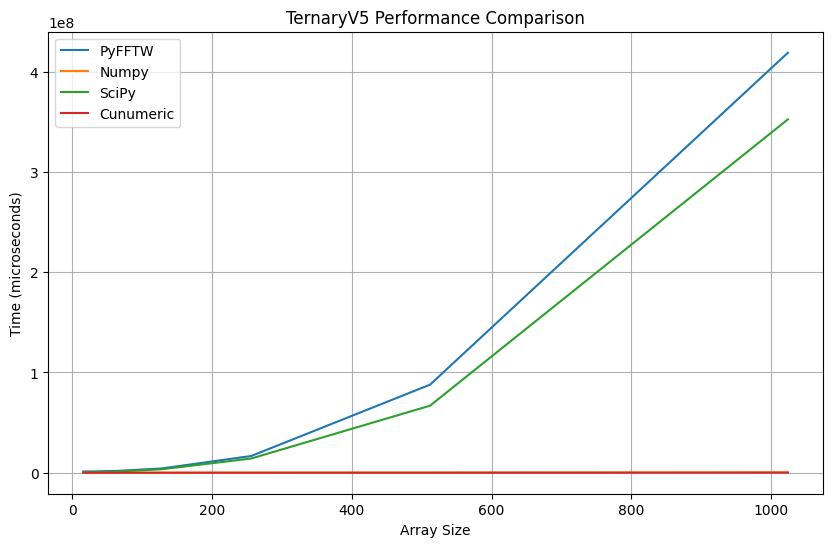

In [9]:
sizes = [16, 32, 64, 128, 256, 512, 1024]

# Measure time taken for each size
time_numpy = []
time_pyfftw = []
time_scipy = []
time_cunumeric = []

for size in sizes:
    time_numpy.append(ternary_numpy(size))
    time_pyfftw.append(ternary_pyfftw(size))
    time_scipy.append(ternary_scipy(size))
    time_cunumeric.append(ternary_cunumeric(size))
    print(f'size {size} done')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(sizes, time_pyfftw, label='PyFFTW')
plt.plot(sizes, time_numpy, label = 'Numpy')
plt.plot(sizes, time_scipy, label='SciPy')
plt.plot(sizes, time_cunumeric, label='Cunumeric')
plt.title('TernaryV5 Performance Comparison')
plt.xlabel('Array Size')
plt.ylabel('Time (microseconds)')
plt.legend()
plt.grid(True)
plt.show()

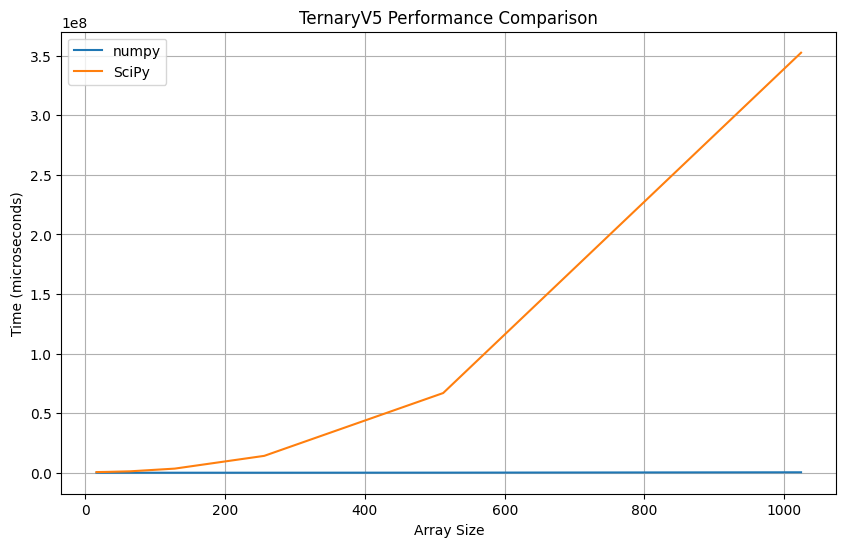

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(sizes, time_numpy, label='numpy')
# plt.plot(sizes,time_pyfftw,label='pyfftw')
plt.plot(sizes, time_scipy, label='SciPy')
# plt.plot(sizes, time_cunumeric, label='Cunumeric')
plt.title('TernaryV5 Performance Comparison')
plt.xlabel('Array Size')
plt.ylabel('Time (microseconds)')
plt.legend()
plt.grid(True)
plt.show()